<a href="https://colab.research.google.com/github/Barrok/BTC_price_prediction/blob/main/script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics
 
import warnings
warnings.filterwarnings('ignore')

In [22]:
# load dataset
df = pd.read_csv('BTC-USD.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-19,3652.377930,3758.533447,3652.377930,3728.568359,3728.568359,5955691380
1,2019-01-20,3725.446045,3743.387939,3583.019531,3601.013672,3601.013672,5582489560
2,2019-01-21,3600.372803,3608.840820,3558.537109,3576.032471,3576.032471,5004347059
3,2019-01-22,3575.081299,3620.746582,3539.721436,3604.577148,3604.577148,5313623556
4,2019-01-23,3605.557129,3623.067871,3565.313965,3585.123047,3585.123047,5433755649


In [4]:
df.shape

(1401, 7)

In [5]:
# basic statistics
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1.401000e+03
mean,23976.500146,24573.403114,23308.342276,23982.776718,23982.776718,3.243484e+10
std,17757.006002,18221.260763,17208.700420,17744.599910,17744.599910,1.890346e+10
min,3401.376465,3427.945557,3391.023682,3399.471680,3399.471680,5.004347e+09
25%,9158.005859,9287.471680,9028.717773,9162.917969,9162.917969,2.038203e+10
50%,18806.765625,19248.068359,18319.822266,18803.656250,18803.656250,2.928040e+10
75%,39316.890625,40418.878906,38112.812500,39294.199219,39294.199219,3.961692e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401 entries, 0 to 1400
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1401 non-null   object 
 1   Open       1401 non-null   float64
 2   High       1401 non-null   float64
 3   Low        1401 non-null   float64
 4   Close      1401 non-null   float64
 5   Adj Close  1401 non-null   float64
 6   Volume     1401 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 76.7+ KB


In [8]:
# check if there are any NULL values
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

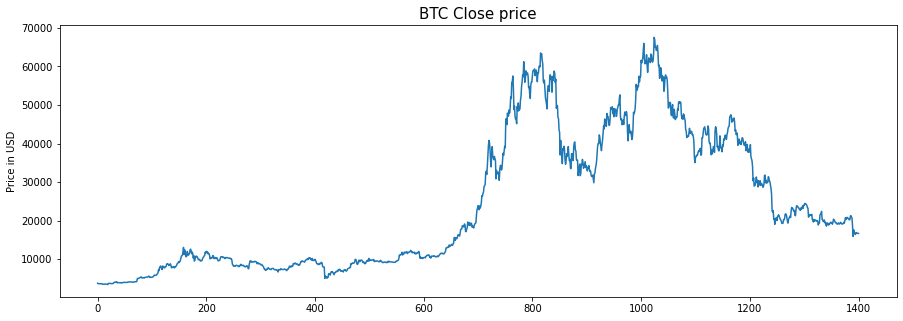

In [64]:
plt.figure(figsize = (15,5))
plt.plot(df['Close'])
plt.title('BTC Close price', fontsize=15)
plt.ylabel('Price in USD')
plt.show()

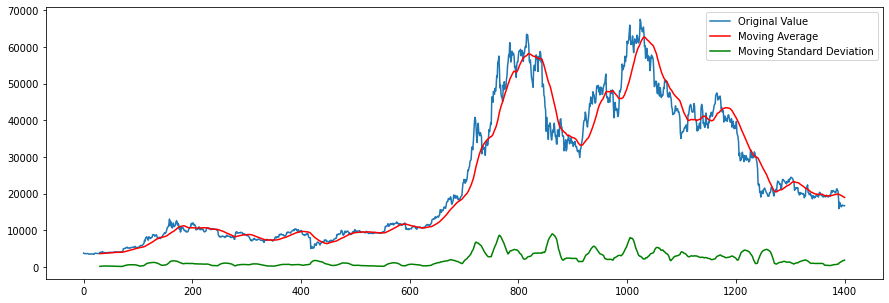

In [71]:
# Visualization of original, rolling mean and standard deviation
close_mean = df['Close'].rolling(window = 31).mean()
close_std = df['Close'].rolling(window = 31).std()
plt.figure(figsize = (15,5))
original = plt.plot(df['Close'], label = 'Original Value')
mean = plt.plot(close_mean, color = 'r', label = 'Moving Average')
std = plt.plot(close_std, color = 'g', label = 'Moving Standard Deviation')
plt.legend(loc = 'best')
plt.show(block = False)

In [75]:
# Dickey–Fuller test
# NULL HYPOTHESIS: The time series is non-stationary. In other words,
# it has some time-dependent structure and does not have constant variance over time.
# ALTERNATIVE HYPOTHESIS: The time series is stationary.
from statsmodels.tsa.stattools import adfuller
X = df['Close'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.491925
p-value: 0.537502
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


We can see that the value is larger than the critical values, meaning that we can fail to reject the null hypothesis and in turn that the time series is non-stationary.

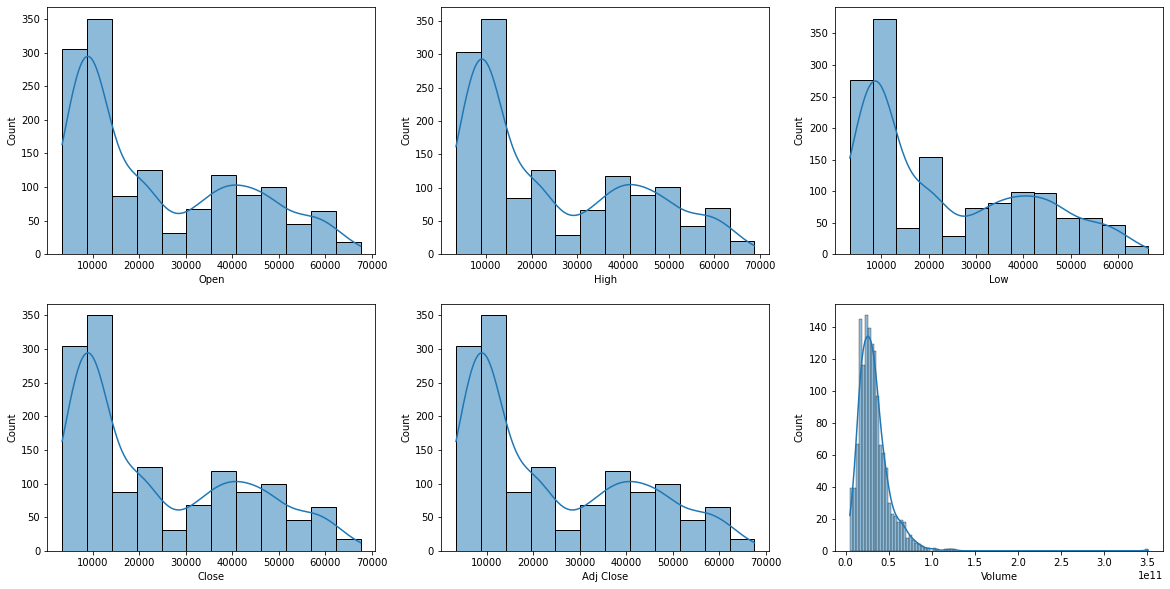

In [9]:
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
 
plt.subplots(figsize=(20,10))
 
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.histplot(df[col], kde = True)
plt.show()

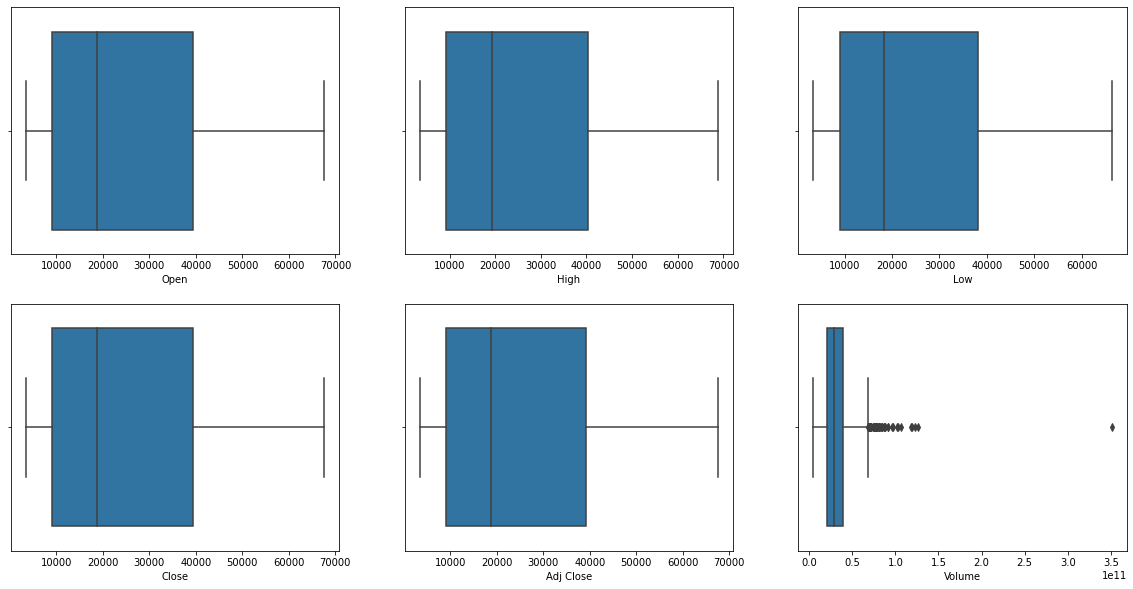

In [10]:
plt.subplots(figsize = (20,10))

for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.boxplot(df[col])
plt.show()

In [11]:
splitted = df['Date'].str.split('-', expand=True)
 
df['year'] = splitted[0].astype('int')
df['month'] = splitted[1].astype('int')
df['day'] = splitted[2].astype('int')
 
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,year,month,day
0,2019-01-19,3652.377930,3758.533447,3652.377930,3728.568359,3728.568359,5955691380,2019,1,19
1,2019-01-20,3725.446045,3743.387939,3583.019531,3601.013672,3601.013672,5582489560,2019,1,20
2,2019-01-21,3600.372803,3608.840820,3558.537109,3576.032471,3576.032471,5004347059,2019,1,21
3,2019-01-22,3575.081299,3620.746582,3539.721436,3604.577148,3604.577148,5313623556,2019,1,22
4,2019-01-23,3605.557129,3623.067871,3565.313965,3585.123047,3585.123047,5433755649,2019,1,23


In [12]:
df['quarter_end'] = np.where(df['month']%3==0,1,0)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,year,month,day,quarter_end
0,2019-01-19,3652.377930,3758.533447,3652.377930,3728.568359,3728.568359,5955691380,2019,1,19,0
1,2019-01-20,3725.446045,3743.387939,3583.019531,3601.013672,3601.013672,5582489560,2019,1,20,0
2,2019-01-21,3600.372803,3608.840820,3558.537109,3576.032471,3576.032471,5004347059,2019,1,21,0
3,2019-01-22,3575.081299,3620.746582,3539.721436,3604.577148,3604.577148,5313623556,2019,1,22,0
4,2019-01-23,3605.557129,3623.067871,3565.313965,3585.123047,3585.123047,5433755649,2019,1,23,0


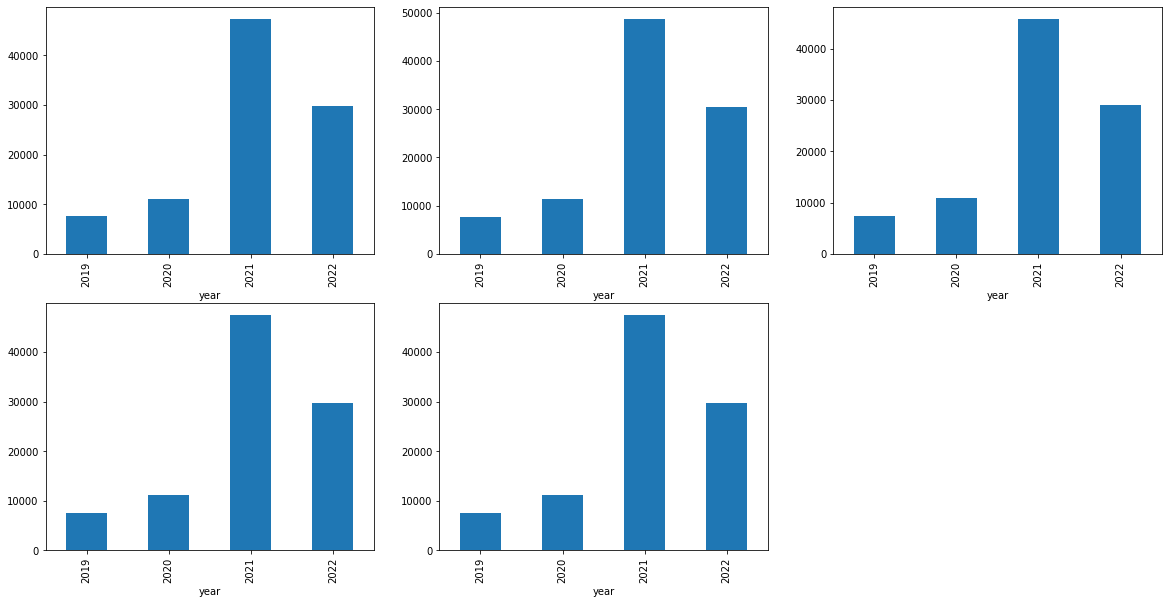

In [13]:
data_grouped = df.groupby('year').mean()
plt.subplots(figsize=(20,10))
 
for i, col in enumerate(['Open', 'High', 'Low', 'Close', 'Adj Close']):
  plt.subplot(2,3,i+1)
  data_grouped[col].plot.bar()
plt.show()

In [14]:
df.groupby('quarter_end').mean()

,Open,High,Low,Close,Adj Close,Volume,year,month,day
quarter_end,,,,,,,,,
0,24201.998352,24811.552815,23537.564164,24218.953261,24218.953261,3.317302e+10,2020.510593,6.070975,15.727754
1,23510.700789,24081.470252,22834.851110,23494.919701,23494.919701,3.091003e+10,2020.398249,7.194748,15.737418


In [17]:
df['open-close']  = df['Open'] - df['Close']
df['low-high']  = df['Low'] - df['High']
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
df.corr()

,Open,High,Low,Close,Adj Close,Volume,year,month,day,quarter_end,open-close,low-high,target
Open,1.000000,0.999198,0.998493,0.997952,0.997952,0.439742,0.658602,-0.021911,-0.019546,-0.018258,0.042906,-0.716619,-0.043047
High,0.999198,1.000000,0.998380,0.999087,0.999087,0.448074,0.656848,-0.024934,-0.018885,-0.018791,0.012651,-0.728210,-0.043900
Low,0.998493,0.998380,1.000000,0.998956,0.998956,0.421595,0.659465,-0.017412,-0.020544,-0.019151,0.003686,-0.688033,-0.045930
Close,0.997952,0.999087,0.998956,1.000000,1.000000,0.436297,0.657081,-0.022318,-0.020133,-0.019136,-0.021089,-0.709634,-0.045871
Adj Close,0.997952,0.999087,0.998956,1.000000,1.000000,0.436297,0.657081,-0.022318,-0.020133,-0.019136,-0.021089,-0.709634,-0.045871
Volume,0.439742,0.448074,0.421595,0.436297,0.436297,1.000000,0.341362,-0.132855,-0.002303,-0.056144,0.058612,-0.636466,-0.024044
year,0.658602,0.656848,0.659465,0.657081,0.657081,0.341362,1.000000,-0.093018,-0.025147,-0.047965,0.030947,-0.433987,-0.046325
month,-0.021911,-0.024934,-0.017412,-0.022318,-0.022318,-0.132855,-0.093018,1.000000,-0.015894,0.157548,0.006108,0.108267,-0.008210
day,-0.019546,-0.018885,-0.020544,-0.020133,-0.020133,-0.002303,-0.025147,-0.015894,1.000000,0.000515,0.008949,-0.006590,0.004886
quarter_end,-0.018258,-0.018791,-0.019151,-0.019136,-0.019136,-0.056144,-0.047965,0.157548,0.000515,1.000000,0.013514,0.008984,-0.004545


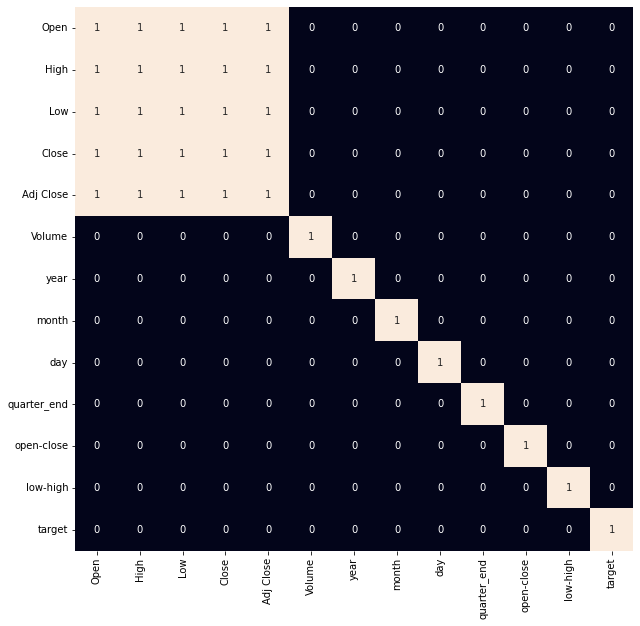

In [18]:
plt.figure(figsize=(10, 10))
 
# As our concern is with the highly
# correlated features only so, we will visualize
# our heatmap as per that criteria only.
sb.heatmap(df.corr() > 0.9, annot=True, cbar=False)
plt.show()

In [19]:
features = df[['open-close', 'low-high', 'quarter_end']]
target = df['target']
 
scaler = StandardScaler()
features = scaler.fit_transform(features)
 
X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.1, random_state=2022)
print(X_train.shape, X_valid.shape)

(1260, 3) (141, 3)


In [76]:
models = [LogisticRegression(), SVC(
  kernel='poly', probability=True), XGBClassifier()]
 
for i in range(3):
  models[i].fit(X_train, Y_train)
 
  print(f'{models[i]} : ')
  print('Training Accuracy : ', metrics.roc_auc_score(
    Y_train, models[i].predict_proba(X_train)[:,1]))
  print('Validation Accuracy : ', metrics.roc_auc_score(
    Y_valid, models[i].predict_proba(X_valid)[:,1]))
  print()

LogisticRegression() : 
Training Accuracy :  0.5229307546488764
Validation Accuracy :  0.5441176470588236

SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.491200769364744
Validation Accuracy :  0.5553988718775181

XGBClassifier() : 
Training Accuracy :  0.7833801565485611
Validation Accuracy :  0.5150080580177276



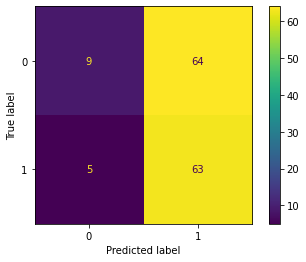

In [78]:
metrics.plot_confusion_matrix(models[0], X_valid, Y_valid)
plt.show()